# Controllo DoFs per struttura Q3_+02_+08 con input5

Codice specifico per struttura Q3_+02_+08, input 5. 

Nelle prime sezioni il programma controlla in tensione i canali specificati nella lista "channels" con uno sweep da "voltage_start'' a ''voltage_stop'' per poi tornare a "voltage_start'', legge le rispettive tensioni e correnti, le salva su file, genera screenshot progressivi e le visualizza a video con grafici. 

L'ultima sezione permette di cambiare dinamicamente le tensioni dei termistori che dovrebbero rappresentare i principali DoF per controllare il percorso della luce con input 5. Permette inoltre di salvare su file la configurazione e catturare uno screenshot. 



## 1) Import

In [1]:
# Required imports
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
path_to_MyCustomPackage = '../' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_MyCustomPackage)
from MyCustomPackage import mycustommodule
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from matplotlib.patches import Polygon
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
from IPython.display import clear_output
import qontrol
import os
import time
import numpy as np
import datetime
import os.path
import math
import wx

app = wx.App(False) # If you get the error The wx.App object must be created first!, uncomment this line


%matplotlib widget

## 2) Dichiarazione variabili e setup driver

In [2]:
# Variable declarations
voltage = 12.0
repetitions = 1
#channels = [4] # the channels connected to the device
#channels = [1,4,6,8,9,10,12,13,15,17,18,19,20,21,23,25]
channels = [4,8,9,17,18,15,19,20,21,23,25]
#channels = [1,4,6,8,9,10,11X,12,13,15,16X,17,18,19,20,21,22X,23,25,26X,27X]
#channels = [k for k in range(10)] # the channels connected to the device
channel_PD = 3 # the channel connected to the photodiode
voltage_PD = 0 # the voltage to be set to the photodiode
voltage_start = [0.0 for j in range(len(channels))] # starting voltage values for each channel
voltage_stop = [voltage for j in range(len(channels))] # stopping voltage values for each channel
voltage_step = [0.5 for j in range(len(channels))] # voltage steps for each channel
max_current = 10 # current compliance
max_voltage = 12.0 # voltage compliance
measured_voltage = [[[] for i in range(len(channels))] for j in range(len(channels))] # measured_voltage[channels][channel_under_sweep][measurement]
measured_current = [[[] for i in range(len(channels))] for j in range(len(channels))] # current measurements
PD_voltage = [[] for i in range(len(channels))] # PD voltage measurements
PD_current = [[] for i in range(len(channels))] # PD current measurements
F_move_on = 0 # FLAG : 0 for pausing when a channel sweep is done
F_overlapping_plots = 1 # FLAG : 0 for non overlapping plots, not 0 otherwise 
F_triangular = 1 # FLAG : 0 for ramp sweep, 1 for triangular sweep
now = datetime.datetime.now() # retrieve current date and time (for file name)

# Configuration (Laser and Amplifier)
laser_wavelength = 850
laser_power = 4.93
amplifier_gain = 40

device = "Q3_+02_+08_" + str(voltage)  + "V_2sweep"

# Set the right path and file


#Create a custom directory
today = str(datetime. date. today()) 
curr_year = today[:4]; curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute   
    
# Directory
directory = curr_year + curr_month + curr_day + str(hour) + str(minute)
  
# Parent Directory path
save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/Q3_+02_+08/"
  
# Path
path = os.path.join(save_path, directory)
  
# Create the directory
os.mkdir(path)
print("Directory '% s' created" % directory)

file_name = "Single_channel_control_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
completeName = os.path.join(path, file_name)

# Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
timestamp = '%'+now.strftime("%d/%m/%Y %H:%M:%S")
configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'
# LEFT          RIGHT
# 1              1
# 2              2
annotation = '\n%TEST CON PIU\' TERMISTORI. NESSUN CANALE CONNESSO AL FOTODIODO\n'

voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
for element in voltage_start:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_stop:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_step:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%' + str(F_triangular) + '\n'

description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
header = timestamp+configuration+annotation+voltage_parameters+description

# Write the header and the column headers to the file
meas_file = open(completeName, "a")
meas_file.write(header)
meas_file.write("\n%PD at channel " + str(channel_PD) + ": Voltage [V]\tCurrent [mA]")
for j in range(len(channels)):
    meas_file.write("\tChannel " +str(channels[j]) + " : Voltage [V]\tCurrent [mA]")
#meas_file.write("\tTimestamp")
meas_file.write("\tID")
meas_file.write("\n")


# Setup Qontroller
serial_port_name = "COM3" #"COM3" #"/dev/tty.usbserial-FT06QAZ5" # name of the USB Serial Port #//./COM11
q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)

# Set the compliances
for channel in range(q.n_chs):
    q.imax[channel] = max_current
    q.vmax[channel] = max_voltage

# Video Debugging
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )

Directory '202203021706' created
Qontroller 'Q8b-0471' initialised with firmware v2.4.1 and 32 channels


## 3) Acquisizione e visualizzazione dati

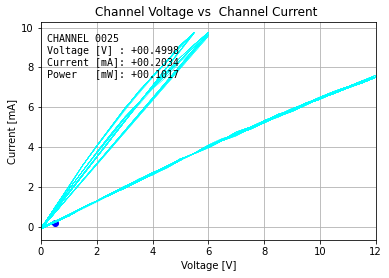

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
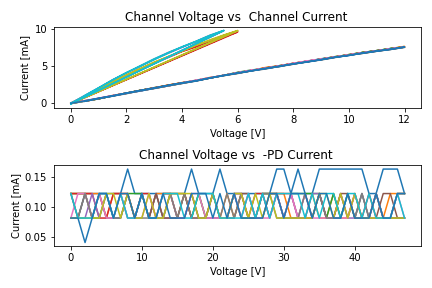

In [3]:
# PD voltage setting
q.v[channel_PD] = voltage_PD

#Set current for channel K
#q.i[K] = I

# Plot results
fig = plt.figure()
ax = fig.gca()
[thispoint] = ax.plot(0, 0, 'bo')

ax.set_title('Channel Voltage vs  Channel Current ')
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('Current [mA]')
ax.set_xlim([0, max(voltage_stop)])
ax.set_ylim(bottom=0, auto=True)
ax.grid()

textstr = 'Current: '

#thispoint_text = ax.text(max(voltage_stop)/2, 0.95, textstr)
thispoint_text = ax.text(ax.get_xlim()[0], ax.get_ylim()[1], textstr, verticalalignment = 'top', fontfamily = 'monospace')

"""
#Generate univoque ID # Creating a unique ID composed of [year][month][day][hour][minute][000] + total_counter (incremented at each row of measurements)
today = str(datetime.date.today()) 
curr_year = today[:4] 
curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute
"""
#curr_year + curr_month + curr_day + str(hour) + str(minute) + "0000"

# Create an ID an initialize it to a number of zeros equal to the maximum length of the total steps
ID = "1"

if F_triangular == 1:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*repetitions*2)
else:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*repetitions)

for i in range(len(str(total_steps))):
    ID = ID + "0"


# Perform a voltage sweep for each channel    
for channel_n in range(len(channels)):
    
    F_move_on = 1 #int(input("Do you want to move to channel " + str(channels[channel_n]) + "? Skip -> 0 Do the swipe -> 1\n"))  
    if F_move_on == 1: # ask wheter to execute or skip current swipe

        print("\nDRIVING CHANNEL {:} NOW \n" .format(channels[channel_n]))

        # set all channels to their voltage_start values
        for k in range(len(channels)):
            q.v[channels[k]] = float(voltage_start[k])

        #check if we want to generate a triangular sweep or not
        if F_triangular == 1:
            sweep_range = np.concatenate((np.arange(voltage_start[channel_n], voltage_stop[channel_n], voltage_step[channel_n]),\
                            np.arange(voltage_stop[channel_n], voltage_start[channel_n], -voltage_step[channel_n])))
        elif F_triangular == 0:
            sweep_range = np.arange(voltage_start[0], voltage_stop[0]+voltage_step[0], voltage_step[0])
        else:
            print('invalid value for triangular')
        for z in range(repetitions):
            for voltage_sweep in sweep_range: 
                q.v[channels[channel_n]] = float(voltage_sweep)
                temp_voltage = q.v[channel_PD]
                temp_current = -q.i[channel_PD]
                PD_voltage[channel_n].append(temp_voltage)
                PD_current[channel_n].append(temp_current)
                #print("PD [ch {:}] : Voltage -> {:} V, Current -> {:} mA" .format(channel_PD, temp_voltage, temp_current))
                meas_file.write('{:+010.6f}\t{:+010.6f}' .format(temp_voltage,  temp_current))

                for j in range(len(channels)): # acquire voltage and current for all channels. Then print them on screen and save them on file
                    temp_voltage = q.v[channels[j]]
                    temp_current = q.i[channels[j]]
                    measured_voltage[j][channel_n].append(temp_voltage)
                    measured_current[j][channel_n].append(temp_current)
                    #print("Channel {:} : Voltage -> {:} V, Current -> {:} mA" .format(channels[j], temp_voltage, temp_current))
                    meas_file.write("\t{:+010.6f}\t{:+010.6f}" .format(temp_voltage, temp_current))
                
                
                # ------------------------------------------------------------------------------               
                
                ID = int(ID) + 1
                
                #meas_file.write("\t" + now.strftime("%d/%m/%Y-%H:%M:%S"))
                meas_file.write("\t" + str(ID))
                
                # Take a screenshot
                mycustommodule.take_screenshot(image_name = str(ID), save_path = path) 
                # --------------------------------------------------------------------------------
                
                meas_file.write("\n")
                
                i = channel_n
                
                clear_output(wait=True)
                ax.plot(measured_voltage[i][i],measured_current[i][i], color='cyan', linewidth=0.1)
                thispoint.set_xdata(measured_voltage[i][i][-1])
                thispoint.set_ydata(measured_current[i][i][-1])
                
                thispoint_text.set_text('\n CHANNEL {:04.0f} \n Voltage [V] : {:+08.4f} \n Current [mA]: {:+08.4f} \n Power   [mW]: {:+08.4f} \n' \
                                        .format(channels[i], measured_voltage[i][i][-1], measured_current[i][i][-1], \
                                         # measured_voltage[i][i][-1]/(measured_current[i][i][-1]/1000),\
                                         measured_voltage[i][i][-1]*measured_current[i][i][-1]))
                
                thispoint_text.set_position((ax.get_xlim()[0], ax.get_ylim()[1]))
                display(fig)
                plt.close()
                plt.pause(0.05)

        # at the end of each sweep, set all channels to their voltage_start values
        for k in range(len(channels)):
            q.v[channels[k]] = float(voltage_start[k])
    else:
        continue


        
# Plot results
fig, axs = plt.subplots(2,1)

axs[0].set_title('Channel Voltage vs  Channel Current ')
axs[0].set_xlabel('Voltage [V]')
axs[0].set_ylabel('Current [mA]')
axs[1].set_title('Channel Voltage vs  -PD Current ')
axs[1].set_xlabel('Voltage [V]')
axs[1].set_ylabel('Current [mA]')

for i in range(len(channels)):
    #print("\nPLOTS FOR DRIVING CHANNEL {:} \n" .format(channels[i]))
    if F_overlapping_plots == 0:
        axs[0].plot(range(i*len(measured_current[i][i]),(i+1)*len(measured_current[i][i])), measured_current[i][i])
        axs[1].plot(range(i*len(measured_current[i][i]),(i+1)*len(measured_current[i][i])), PD_current[i])
    else:
        axs[0].plot(measured_voltage[i][i], measured_current[i][i])
        axs[1].plot(range(len(measured_current[i][i])), PD_current[i])
plt.tight_layout()

# Close the log file
meas_file.close()

# Set all channels to zero
#q.v[:] = 0
#q.i[:] = 0

# Close the communication with the driver
q.close()

In [ ]:
%matplotlib widget                                       
axis_color = 'lightgoldenrodyellow'

hf_general = plt.figure()
hf_general.set_size_inches(15, 8, forward=True)
ha_general = hf_general.add_subplot(121)      # Output intensities (simulated)

# Adjust the subplots region to leave some space for the sliders and buttons
hf_general.subplots_adjust(bottom=0.30)
ha_general.set_title('Channel Voltage vs  Channel Current ')
ha_general.set_xlabel('Voltage [V]')
ha_general.set_ylabel('Current [mA]')
ha_general.set_xlim([-0.1, max(voltage_stop)])
ha_general.set_ylim([-0.1, 20])
ha_general.grid()
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'c', 'm', 'y', 'k'])))



# Draw the initial plot(s) and text(s)
# The 'line' variable is used for modifying the line later
lines = []
z = 0

for x in range(7):
    if x == 4:
        z = 1
    [line] = ha_general.plot(0, 0, marker='o', label='T' + str(20-x-z) + 'T16 - CH' + str(3+x))
    lines.append(line)

ha_general.legend()  
    
locator = MaxNLocator(nbins=6)

F_overlapping_plots = 1


B01_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B01',
    continuous_update=True)

B04_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B04',
    continuous_update=True) 

B06_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B06',
    continuous_update=True) 

B08_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B08',
    continuous_update=True) 

B09_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B09',
    continuous_update=True) 

B10_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B10',
    continuous_update=True) 

B11_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B11',
    continuous_update=True) 

B12_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B12',
    continuous_update=True) 

B13_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B13',
    continuous_update=True) 

B15_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B15',
    continuous_update=True) 

B16_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B16',
    continuous_update=True) 

B17_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B17',
    continuous_update=True) 

B18_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B18',
    continuous_update=True) 

B19_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B19',
    continuous_update=True) 

B20_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B20',
    continuous_update=True) 

B21_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B21',
    continuous_update=True) 

B22_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B22',
    continuous_update=True)  

B23_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B23',
    continuous_update=True)

B25_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B25',
    continuous_update=True) 

B26_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B26',
    continuous_update=True) 

B27_slider = widgets.FloatSlider(
    value=1, 
    min=0, max=voltage, step=0.1,
    description='B27',
    continuous_update=True) 

def plot(B01_slider, B04_slider, B06_slider, B08_slider, B09_slider, B10_slider, B11_slider, \
        B12_slider, B13_slider, B15_slider, B16_slider, B17_slider, B18_slider, B19_slider, \
        B20_slider, B21_slider, B22_slider, B23_slider, B25_slider, B26_slider, B27_slider):
    
    q.v[1] = float(B01_slider)
    q.v[4] = float(B04_slider)
    q.v[6] = float(B06_slider)
    q.v[8] = float(B08_slider)
    q.v[9] = float(B09_slider)
    q.v[10] = float(B10_slider)
    q.v[11] = float(B11_slider)
    q.v[12] = float(B12_slider)
    q.v[13] = float(B13_slider)
    q.v[15] = float(B15_slider)
    q.v[16] = float(B16_slider)
    q.v[17] = float(B17_slider)
    q.v[18] = float(B18_slider)
    q.v[19] = float(B19_slider)
    q.v[20] = float(B20_slider)
    q.v[21] = float(B21_slider)
    q.v[22] = float(B22_slider)
    q.v[23] = float(B23_slider)
    q.v[25] = float(B25_slider)
    q.v[26] = float(B26_slider)
    q.v[27] = float(B27_slider)

    
    for x in range(7):
        temp_voltage = q.v[x+3]
        temp_current = q.i[x+3]
        lines[x].set_xdata(temp_voltage)
        lines[x].set_ydata(temp_current)
    hf_general.canvas.draw() 

output = widgets.Output()
save_button = widgets.Button(description="Save Configuration")

@output.capture()
def on_save_button_clicked(b):
    #print(type(b))
    save_config()
    print("Configuration Saved.")
    b.icon="warning"

save_button.on_click(on_save_button_clicked)

exit_button = widgets.Button(description="Exit")

@output.capture()
def on_exit_button_clicked(b):
    q.v[:] = 0
    q.i[:] = 0
    # Close the communication with the driver
    q.close()
    print("Exit successfully.")

exit_button.on_click(on_exit_button_clicked)
    
    
def save_config():
    # Set the right path and file
    #save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/"+ device_model +"/"
    save_path = path
    file_name = "Algoritmo_di_ricerca_output_massimo_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device 
    completeName = os.path.join(save_path, file_name)

    # Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
    timestamp = now.strftime("%d/%m/%Y %H:%M:%S")
    configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'

    annotation = "\n%RIPRODOTTA CONFIGURAZIONE A SINGOLO OUTPUT DEL" + timestamp + ". CONFIGURAZIONE SALVATA PER I TERMISTORI:\n'
    termistori = "%" + str(channels) + "\n" #1,4,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,25,26,27\n'
    header = '%'+timestamp+configuration+annotation+termistori

    # Write the header and the column headers to the file
    config_file = open(completeName, "a")
    config_file.write(header)
    config_file.close()
    config_file = open(completeName + '.txt', "a")

    parameters = str(B01_slider.value) + '\n' + str(B04_slider.value) + '\n' + str(B06_slider.value) + '\n' + \
                 str(B08_slider.value) + '\n' + str(B09_slider.value) + '\n' + str(B10_slider.value) + '\n' + \
                 str(B11_slider.value) + '\n' + str(B12_slider.value) + '\n' + str(B13_slider.value) + '\n' + \
                 str(B15_slider.value) + '\n' + str(B16_slider.value) + '\n' + str(B17_slider.value) + '\n' + \
                 str(B18_slider.value) + '\n' + str(B19_slider.value) + '\n' + str(B20_slider.value) + '\n' + \
                 str(B21_slider.value) + '\n' + str(B22_slider.value) + '\n' + str(B23_slider.value) + '\n' + \
                 str(B25_slider.value) + '\n' + str(B26_slider.value) + '\n' + str(B27_slider.value) + '\n'
    
    # Write the actual configuration for each DoF
    config_file.write(parameters)
    
    # Take a screenshot
    mycustommodule.take_screenshot(image_name = file_name, save_path = path) 
    
    config_file.close()

z = interactive(plot, B01_slider=B01_slider, B04_slider=B04_slider, B06_slider=B06_slider, B08_slider=B08_slider, B09_slider=B09_slider, \
                B10_slider=B10_slider, B11_slider=B11_slider, B12_slider=B12_slider, B13_slider=B13_slider, B15_slider=B15_slider, \
                B16_slider=B16_slider, B17_slider=B17_slider, B18_slider=B18_slider, B19_slider=B19_slider, \
                B20_slider=B20_slider, B21_slider=B21_slider, B22_slider=B22_slider, B23_slider=B23_slider, B25_slider=B25_slider, \
                B26_slider=B26_slider, B27_slider=B27_slider)
display(z, save_button, exit_button, output)

plt.show()

## How to take a screenshot!

In [ ]:
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
path_to_MyCustomPackage = '../' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_MyCustomPackage)
from MyCustomPackage import mycustommodule
import wx
import datetime

#app = wx.App(False)

In [ ]:
mycustommodule.take_screenshot(image_name="test4")

In [ ]:
 
today = str(datetime. date. today()) 
curr_year = today[:4]; curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

print("Current year:", curr_year)
print("Current month:", curr_month)
print("Current day:", curr_day)
#print(datetime.datetime.now().hour)
if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute
print("Current hour:", hour)
print("Current min:", minute)

for i in range(15):
    ID = curr_year + curr_month + curr_day + str(hour) + str(minute) + "000"
    ID = int(ID) + i
    print("ID generated is: " + str(ID))

In [ ]:
# importing os module
import os
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
path_to_MyCustomPackage = '../' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_MyCustomPackage)
from MyCustomPackage import mycustommodule
#mycustommodule.take_screenshot(image_name="test3")
import datetime
  

today = str(datetime. date. today()) 
curr_year = today[:4]; curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

print("Current year:", curr_year)
print("Current month:", curr_month)
print("Current day:", curr_day)
#print(datetime.datetime.now().hour)
if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute
print("Current hour:", hour)
print("Current min:", minute)    

    
    
# Directory
directory = curr_year + curr_month + curr_day + str(hour) + str(minute)
  
# Parent Directory path
save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/Q3_+02_+08/"
parent_dir = save_path 
  
# Path
path = os.path.join(parent_dir, directory)
  
# Create the directory
# 'GeeksForGeeks' in
# '/home / User / Documents'
os.mkdir(path)
print("Directory '% s' created" % directory)

In [ ]:
if F_triangular == 1:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*repetitions*2)
else:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*repetitions)
    
print(total_steps)
print(len(str(total_steps)))
ID = ""

for i in range(len(str(total_steps))):
    ID = ID + "0"
print(ID)